# 텍스트 기반 긍-부정 감정 판별

- Last Updated : 2021/07/23
- Author : **Song Kitae** (Department of AI Software, Dankook Software High School)
- Title : sentiment_classification.ipynb
- Use Module : **`Tensorflow 2`**, **`Keras`**....
- Key Word : 딥러닝, 문장 인식, 감정 분석

# Abstract
1. SST2, Twitter, Reddit을 합친 데이터셋을 학습하여 감정 분석 인공지능을 제작함.
2. 영어로 된 문장의 감정 상태를 예측하여 글을 쓴 사람의 감정 상태(긍-부정)을 판단함.
3. 영어로 된 문장을 판별하는데 90%의 정확도를 얻어냄.

In [171]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.5.0
1.1.5
1.19.5


# 데이터셋
- 본 모델은 아래의 데이터들을 토대로 학습합니다. (총 138,785 문장)
    - Stanford Sentiment Treebank (i.e. SST2) : (6,920 문장)
    - Twitter : (82,914 문장)
    - Reddit : (24,107 문장)
    - 여러 사이트를 돌아다니며 모은 문장 : (24,844 문장)

,data,label
70303,very important article that emphasizes how imp...,1


   label  count
0      0  47096
1      1  91689


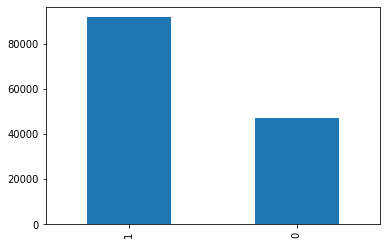

In [175]:
df = pd.read_csv("train.csv")
# 인덱스 부분 삭제
del df["Unnamed: 0"]

# Train, Test 분리
train_x, test_x, train_y, test_y = train_test_split(df["data"], df["label"], test_size=0.33, random_state=42)
train_x=np.array(train_x); test_x=np.array(test_x); train_y=np.array(train_y); test_y=np.array(test_y)

display(df.loc[df.data == train_x[0]])

# 긍정 데이터 91,689개
# 부정 데이터 47,096개
df["label"].value_counts().plot(kind='bar')
print(df.groupby("label").size().reset_index(name="count"))

In [133]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Keras에서 제공하는 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}

# padding
word_index["<PAD>"] = 0
word_index["<START>"] = 1
# unknown
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

def encode_review(text):
    # text를 단어별로 split, lower해줌
    arr = text_to_word_sequence(text)    
    res = []
    for k, v in enumerate(arr):
        # 딕셔너리에 있는 단어라면 append
        try: res.append(word_index[v])
        # 만약 딕셔너리에 없는 단어이면 Unknown으로 append
        except KeyError: res.append(word_index["<UNK>"])
    return np.array(res)

In [138]:
# train 데이터셋을 하나씩 정수 형태로 encoding함
for k, sentence in enumerate(train_x):
    train_x[k] = encode_review(sentence)
    
# test 데이터셋을 하나씩 정수 형태로 encodeing함
for k, sentence in enumerate(test_x):
    test_x[k] = encode_review(sentence)

print(train_x[0])
print("긍정" if train_y[0] == 1 else "부정")

[   55   674  7753    15 13460    89   674    14  5801    18     4     2
   705   371   985   120     4  1357  2853]
긍정


In [139]:
# 각 문장별로 길이가 다르기 때문에 패딩을 추가함
# 이미 있는 단어는 그대로 냅두고 빈 공간을 0으로 설정

train_x = keras.preprocessing.sequence.pad_sequences(
    train_x,
    value=word_index["<PAD>"],
    padding="post",
    maxlen=512
)

test_x = keras.preprocessing.sequence.pad_sequences(
    test_x,
    value=word_index["<PAD>"],
    padding="post",
    maxlen=512
)

In [140]:
# train과 test 데이터셋 모두 512개로 같은 길이임을 확인할 수 있음
len(train_x[0]), len(train_x[1])

(512, 512)

In [141]:
train_x[0]

array([   55,   674,  7753,    15, 13460,    89,   674,    14,  5801,
          18,     4,     2,   705,   371,   985,   120,     4,  1357,
        2853,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [145]:
vocab_size = 100000

model = keras.Sequential(
    # 단어를 벡터형태로 표현함
    keras.layers.Embedding(vocab_size, 64, input_shape=(None,)),
    # GlobalAveragePooling1D을 이용하여 입력으로 사용되는 리뷰에 포함된 단어 개수가 변경되더라도 같은 크기의 벡터로 처리할 수 있게 됨.
    keras.layers.GlobalAveragePooling1D(),
    # Relu Activation Func 사용
    keras.layers.Dense(64, activation=tf.nn.relu),
    # 33% 확률로 드롭아웃. 오버피팅 방지
    keras.layers.Dropout(0.33),
    # 긍-부정을 확률 형태로 판별하기 위해 0~1사이의 값을 갖는 Activation Func 사용.
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          6400000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,404,225
Trainable params: 6,404,225
Non-trainable params: 0
_________________________________________________________________


In [146]:
# loss func은 binary_crossentropy. 예측한 확률 값과 정답 값의 거리를 측정함
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [147]:
x_val = train_x[:10000]
partial_x_train = train_x[10000:]

y_val = train_y[:10000]
partial_y_train = train_y[10000:]

print(partial_x_train[0])

[  82   67   91   84   37  264    2   26   82 1736  124  192   15   25
   70 1128 7159   19 1736 4774   25  144   79 1578 1908 1459   54 1386
    2    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [148]:
# 학습을 진행하면서 성능이 제일 뛰어난 모델을 사용함
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5", monitor="val_loss", save_best_only=True)

In [149]:
# 40번 학습, 미니 배치 사이즈는 512
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/40
163/163 [==============================] - 19s 114ms/step - loss: 0.6436 - accuracy: 0.6616 - val_loss: 0.6384 - val_accuracy: 0.6617
Epoch 2/40
163/163 [==============================] - 18s 111ms/step - loss: 0.6380 - accuracy: 0.6617 - val_loss: 0.6327 - val_accuracy: 0.6617
Epoch 3/40
163/163 [==============================] - 18s 113ms/step - loss: 0.6185 - accuracy: 0.6619 - val_loss: 0.5926 - val_accuracy: 0.6634
Epoch 4/40
163/163 [==============================] - 18s 112ms/step - loss: 0.5296 - accuracy: 0.7201 - val_loss: 0.4832 - val_accuracy: 0.7200
Epoch 5/40
163/163 [==============================] - 18s 111ms/step - loss: 0.4023 - accuracy: 0.8387 - val_loss: 0.3661 - val_accuracy: 0.8480
Epoch 6/40
163/163 [==============================] - 18s 113ms/step - loss: 0.3147 - accuracy: 0.8880 - val_loss: 0.3128 - val_accuracy: 0.8900
Epoch 7/40
163/163 [==============================] - 18s 112ms/step - loss: 0.2636 - accuracy: 0.9106 - val_loss: 0.2720 - val_ac

In [151]:
results = model.evaluate(test_x, test_y, verbose=3)

# 90.99%의 정확도를 확인할 수 있음
print(results)

[0.32502928376197815, 0.909912645816803]


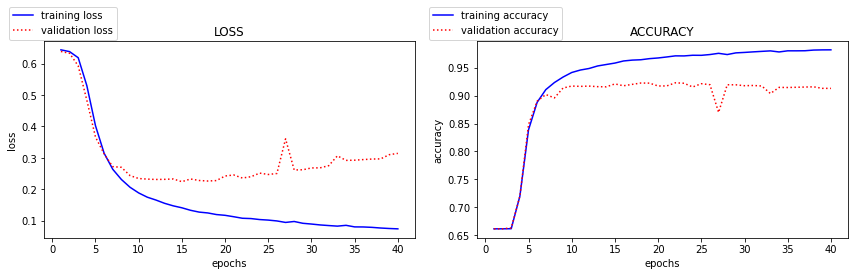

In [152]:
# 모델의 성능을 시각화하는 함수
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

# LOSS 그래프는 우하향을 그리고 있고, ACC 그래프는 우상향을 그리고 있음. (오버피팅이나 언더피팅 X)
plot_history(history)

In [169]:
# TEST
# 내 삶을 위한 첫단계 시작. 혼자서도 잘 지내자. 행복하자 : 1
real_text = [encode_review("Start the first step for my life. Let's get along well on our own. Let's be happy.")]

real_text = keras.preprocessing.sequence.pad_sequences(
    real_text,
    value=word_index["<PAD>"],
    padding="post",
    maxlen=512
)

if model.predict(real_text)[0] > 0.5:
    print(model.predict(real_text)[0])
    print("긍정")
else:
    print(model.predict(real_text)[0])
    print("부정")

[0.9999999]
긍정


# Reference

- [영화 리뷰를 사용한 텍스트 분류  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/text_classification)
- [pytorch-sentiment-classification](https://github.com/clairett/pytorch-sentiment-classification)
- [KoreanSentimentAnalyzer](https://github.com/mrlee23/KoreanSentimentAnalyzer)